In [47]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import unicodedata
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from scalecast import Forecaster


import warnings
warnings.filterwarnings("ignore")

In [48]:
# Load reddit analysis
apple_reddit = pd.read_csv('sentiment-aapl-subreddits.csv')
netflix_reddit = pd.read_csv('sentiment-nflx-subreddits.csv')

print(apple_reddit.head())
print(netflix_reddit.head())

                  date                                       cleaned_text  \
0  2023-07-20 02:29:13  Is now a bad time to do a lump sum purchase of...   
1  2023-07-20 04:56:37  Are we supposed to ignore cumulative inflation...   
2  2023-07-20 17:24:18                                    Major top wicks   
3  2023-07-21 05:26:07        Thanks for the Advice I have added them all   
4  2023-07-21 05:52:35  Selling AAPL, looking for assessments of OLN, ...   

     neg    neu    pos  compound  
0  0.241  0.759  0.000   -0.5423  
1  0.158  0.665  0.177    0.3736  
2  0.000  0.526  0.474    0.2023  
3  0.000  0.707  0.293    0.4404  
4  0.000  0.761  0.239    0.4278  
                  date                                   cleaned_text  neg  \
0  2023-07-20 02:18:47                        This should do alright?  0.0   
1  2023-07-20 13:45:58                  Predictions: Next 1T company?  0.0   
2  2023-07-20 15:27:15  NFLX trade review / PnL: -1.09 R / R2R: -0.89  0.0   
3  2023-07-21 2

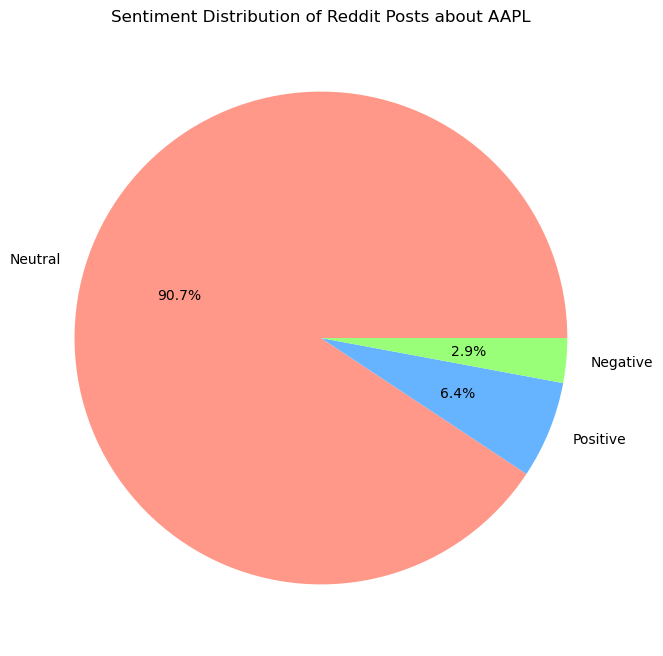

In [49]:
# Determine the sentiment label based on the highest score
def get_sentiment_label(row):
    if row['pos'] > row['neg'] and row['pos'] > row['neu']:
        return 'Positive'
    elif row['neg'] > row['pos'] and row['neg'] > row['neu']:
        return 'Negative'
    else:
        return 'Neutral'

apple_reddit_labels = apple_reddit.copy() 
apple_reddit_labels['sentiment'] = apple_reddit_labels.apply(get_sentiment_label, axis=1)

# Count occurrences of each label
sentiment_counts = apple_reddit_labels['sentiment'].value_counts()

# Plot donut chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#ff9889','#66b3ff','#99ff79'])
plt.title('Sentiment Distribution of Reddit Posts about AAPL')
plt.show()

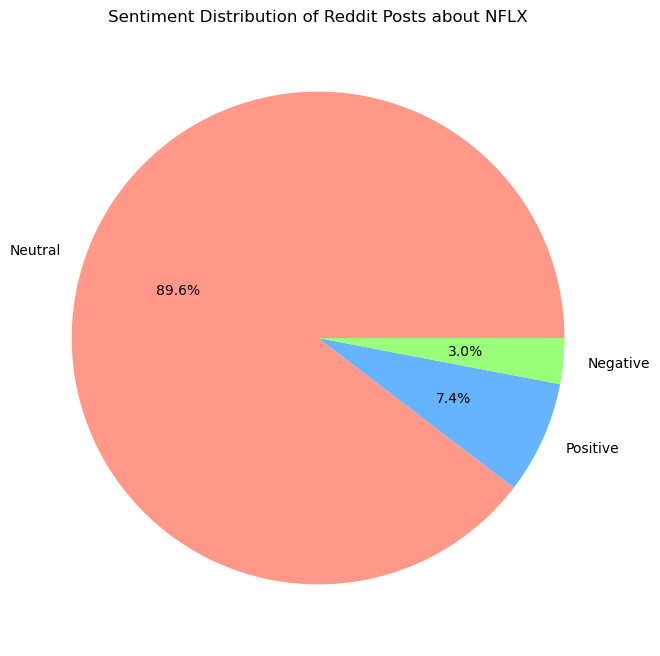

In [50]:
netflix_reddit_labels = netflix_reddit.copy() 
netflix_reddit_labels['sentiment'] = netflix_reddit_labels.apply(get_sentiment_label, axis=1)

# Count occurrences of each label
sentiment_counts = netflix_reddit_labels['sentiment'].value_counts()

# Plot donut chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#ff9889','#66b3ff','#99ff79'])
plt.title('Sentiment Distribution of Reddit Posts about NFLX')
plt.show()

In [51]:
# Load news analysis
apple_news = pd.read_csv('aapl-news-sentiment.csv')
netflix_news = pd.read_csv('nflx-news-sentiment.csv')

print(apple_news.head())
print(netflix_news.head())

         date                                      cleaned_title  compound  \
0  2023-07-19  T Rowes Blue Chip Growth ETF TCHP Plenty to Li...  0.111977   
1  2023-07-19  Bank of America Securities Sticks to Their Hol...  0.070036   
2  2023-07-19   Smart Take 3 Reasons Why Apple Should Buy Disney  0.006923   
3  2023-07-19  Analyst Draws Parallel Between Nvidia And Appl...  0.921360   
4  2023-07-19  Why the Bull Market Rally Will Last Until 2025... -0.004842   

        neg       neu       pos  
0  0.032377  0.823270  0.144353  
1  0.034142  0.861680  0.104178  
2  0.028800  0.935476  0.035723  
3  0.018505  0.041630  0.939865  
4  0.040013  0.924816  0.035171  
         date                                      cleaned_title  compound  \
0  2023-07-19         The 3 Best Streaming Stocks to Buy in July  0.082099   
1  2023-07-19  Netflix Q2 Earnings Today NFLX What You Need t...  0.025134   
2  2023-07-19  4 stocks to watch on Wednesday Goldman Sachs N... -0.002240   
3  2023-07-19  

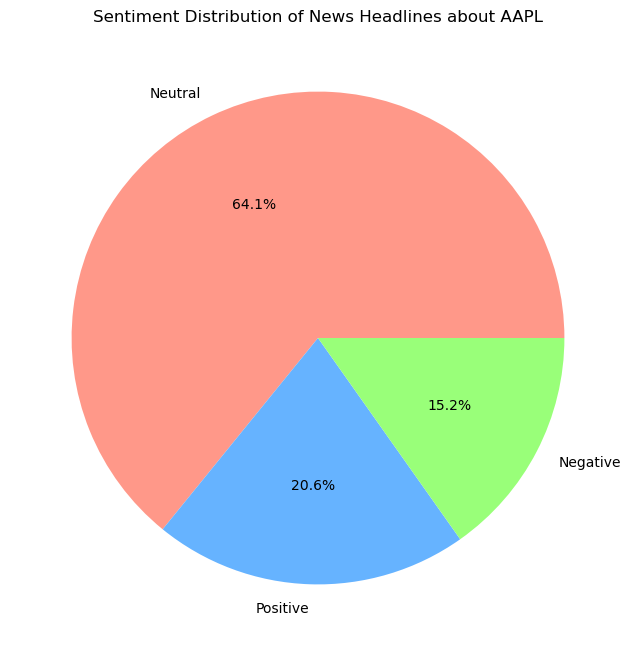

In [52]:
apple_news_labels = apple_news.copy() 
apple_news_labels['sentiment'] = apple_news_labels.apply(get_sentiment_label, axis=1)

# Count occurrences of each label
sentiment_counts = apple_news_labels['sentiment'].value_counts()

# Plot donut chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#ff9889','#66b3ff','#99ff79'])
plt.title('Sentiment Distribution of News Headlines about AAPL')
plt.show()

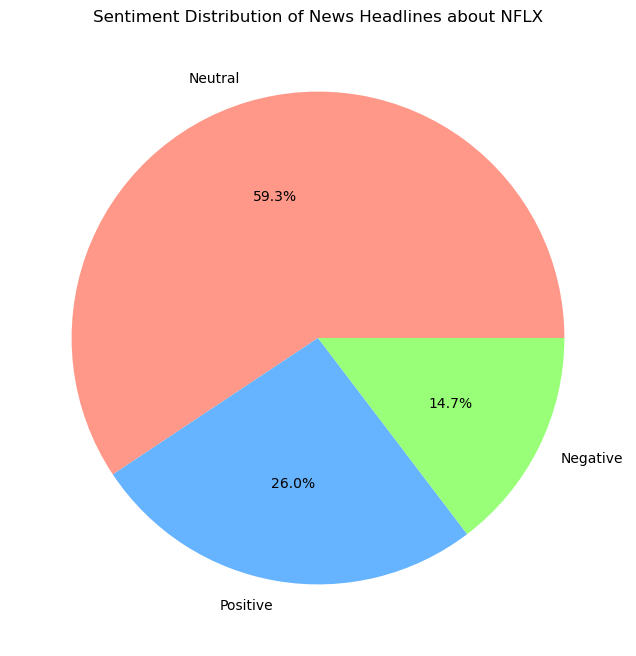

In [53]:
netflix_news_labels = netflix_news.copy() 
netflix_news_labels['sentiment'] = netflix_news_labels.apply(get_sentiment_label, axis=1)

# Count occurrences of each label
sentiment_counts = netflix_news_labels['sentiment'].value_counts()

# Plot donut chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#ff9889','#66b3ff','#99ff79'])
plt.title('Sentiment Distribution of News Headlines about NFLX')
plt.show()

In [54]:
# Load ticker prices
apple_prices = pd.read_csv('apple-prices.csv')
netflix_prices = pd.read_csv('netflix-prices.csv')

print(apple_prices.head())
print(netflix_prices.head())

         Date        Open        High         Low       Close   Adj Close  \
0  2023-07-20  195.089996  196.470001  192.500000  193.130005  192.109756   
1  2023-07-21  194.100006  194.970001  191.229996  191.940002  190.926041   
2  2023-07-24  193.410004  194.910004  192.250000  192.750000  191.731766   
3  2023-07-25  193.330002  194.440002  192.919998  193.619995  192.597153   
4  2023-07-26  193.669998  195.639999  193.320007  194.500000  193.472504   

       Volume    Return  
0  59581200.0 -0.006162  
1  71917800.0 -0.006162  
2  45377800.0  0.004220  
3  37283200.0  0.004514  
4  47471900.0  0.004545  
         Date        Open        High         Low       Close   Adj Close  \
0  2023-07-20  447.000000  448.500000  432.000000  437.420013  437.420013   
1  2023-07-21  437.369995  438.239990  423.190002  427.500000  427.500000   
2  2023-07-24  425.000000  428.640015  419.190002  428.369995  428.369995   
3  2023-07-25  427.179993  430.880005  426.130005  427.700012  427.700012

In [55]:
def merge_dfs(reddit_df, news_df, prices):
    # Fix the date columns and format them to the same type
    reddit_df['date'] = pd.to_datetime(reddit_df['date'], errors='coerce').dt.strftime('%Y-%m-%d')
    news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce').dt.strftime('%Y-%m-%d')
    prices['Date'] = pd.to_datetime(prices['Date'], errors='coerce').dt.strftime('%Y-%m-%d')
    
    # Group sentiment scores by date
    reddit_df = reddit_df[['date', 'compound']].groupby('date').mean().reset_index()
    news_df = news_df[['date', 'compound']].groupby('date').mean().reset_index()
    
    # Merge the two sentiment dfs
    merged = pd.merge(reddit_df, news_df, on='date', how='inner', suffixes=('_reddit', '_news'))
    
    # Second merge with prices
    second_merge = pd.merge(merged, prices, left_on='date', right_on='Date', how='inner')
    second_merge.drop(['Date','Adj Close'], axis = 1, inplace = True)
    second_merge.columns = ['date','reddit_sentiment', 'news_sentiment', 'open', 'high', 'low', 'close', 'volume', 'return']
    second_merge.set_index('date', inplace=True)
    return second_merge

apple = merge_dfs(apple_reddit, apple_news, apple_prices)
apple.to_csv('apple-merged-df.csv')

netflix = merge_dfs(netflix_reddit, netflix_news, netflix_prices)
netflix.to_csv('netflix-merged-df.csv')

print(apple)
print(netflix)


            reddit_sentiment  news_sentiment        open        high  \
date                                                                   
2023-07-20          0.011200       -0.150490  195.089996  196.470001   
2023-07-21          0.285760       -0.174370  194.100006  194.970001   
2023-07-24          0.427750       -0.093626  193.410004  194.910004   
2023-07-25          0.072240        0.294939  193.330002  194.440002   
2023-07-26          0.275667        0.186163  193.669998  195.639999   
...                      ...             ...         ...         ...   
2024-07-15         -0.001917        0.030441  236.479996  237.229996   
2024-07-16          0.003371        0.133982  235.000000  236.270004   
2024-07-17         -0.094990        0.032509  229.449997  231.460007   
2024-07-18          0.083933        0.035976  230.279999  230.440002   
2024-07-19          0.149867       -0.085174  224.820007  226.800003   

                   low       close      volume    return  
date

Time Series of AAPL Features


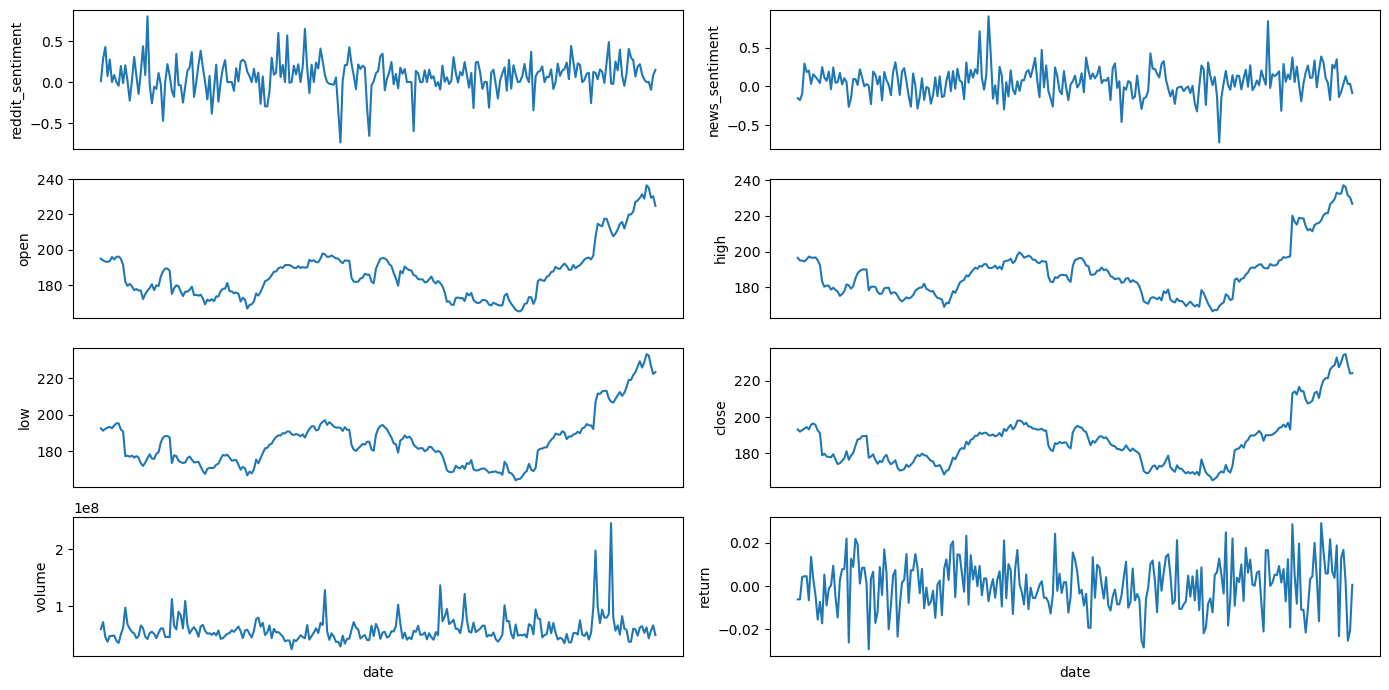

In [56]:

# Plot line charts
apple_plot = apple.copy()

ncols = 2
nrows = int(round(apple_plot.shape[1] / ncols, 0))

print("Time Series of AAPL Features")
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = apple_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.set_xticklabels([])
fig.tight_layout()
plt.show()


Time Series of NFLX Features


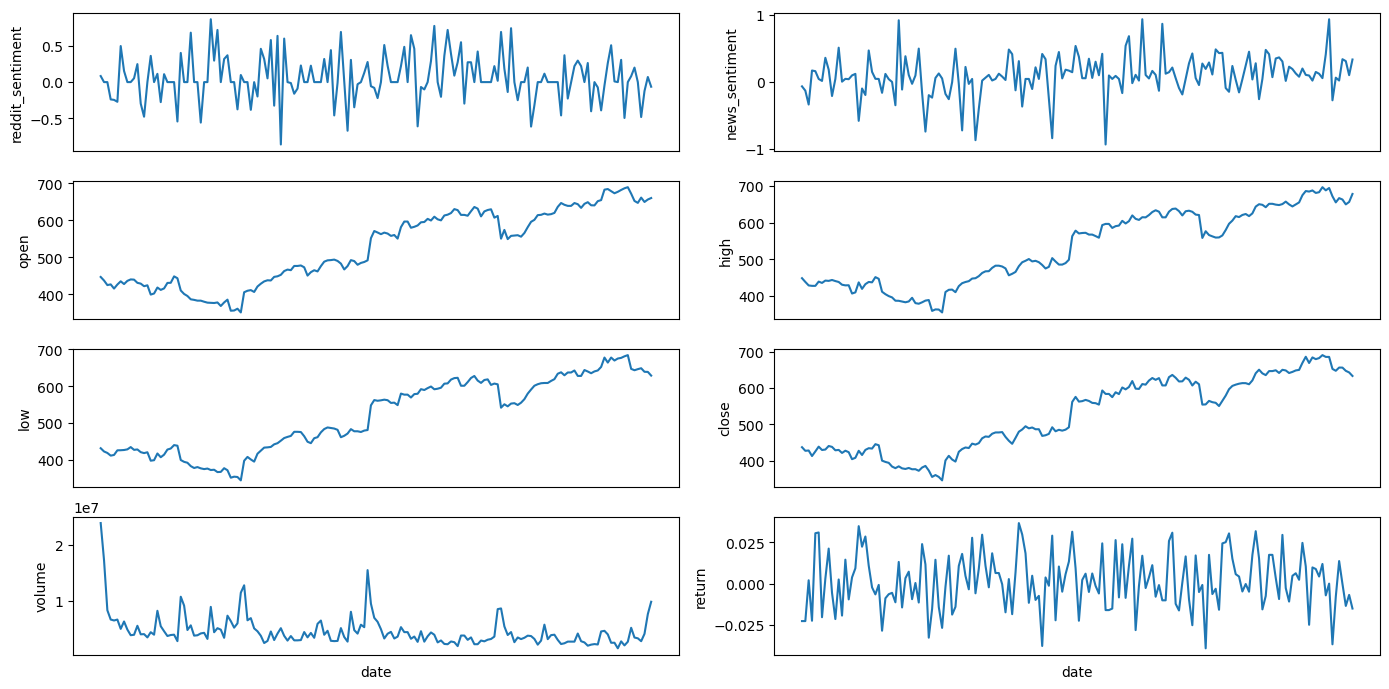

In [57]:
# Plot line charts for Netflix
netflix_plot = netflix.copy()

ncols = 2
nrows = int(round(netflix_plot.shape[1] / ncols, 0))

print("Time Series of NFLX Features")
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = netflix_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.set_xticklabels([])
fig.tight_layout()
plt.show()

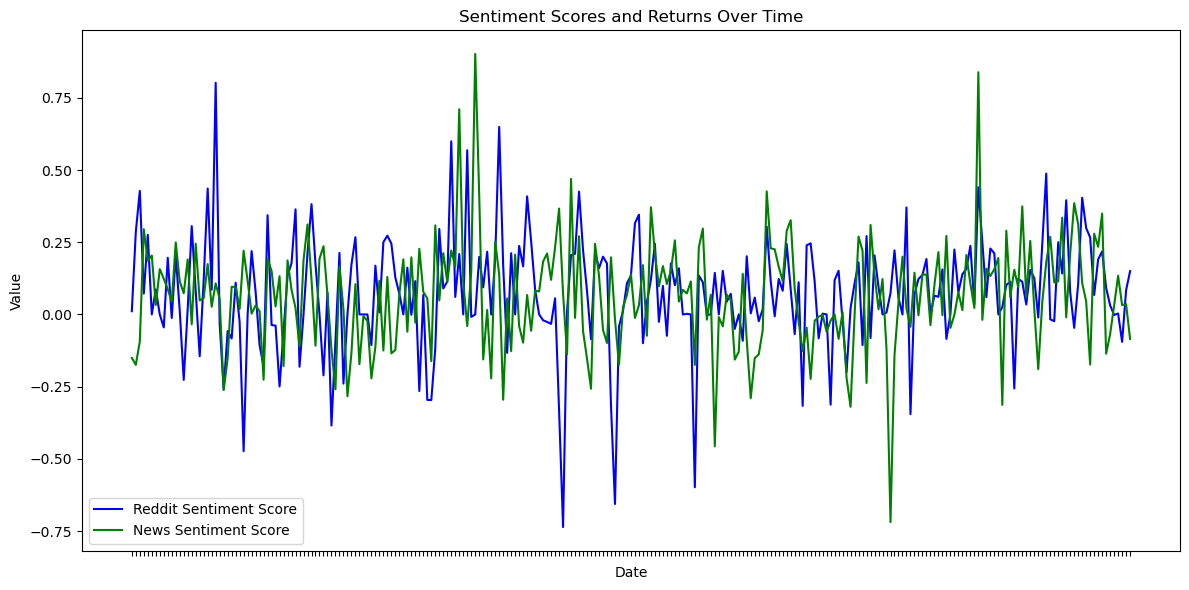

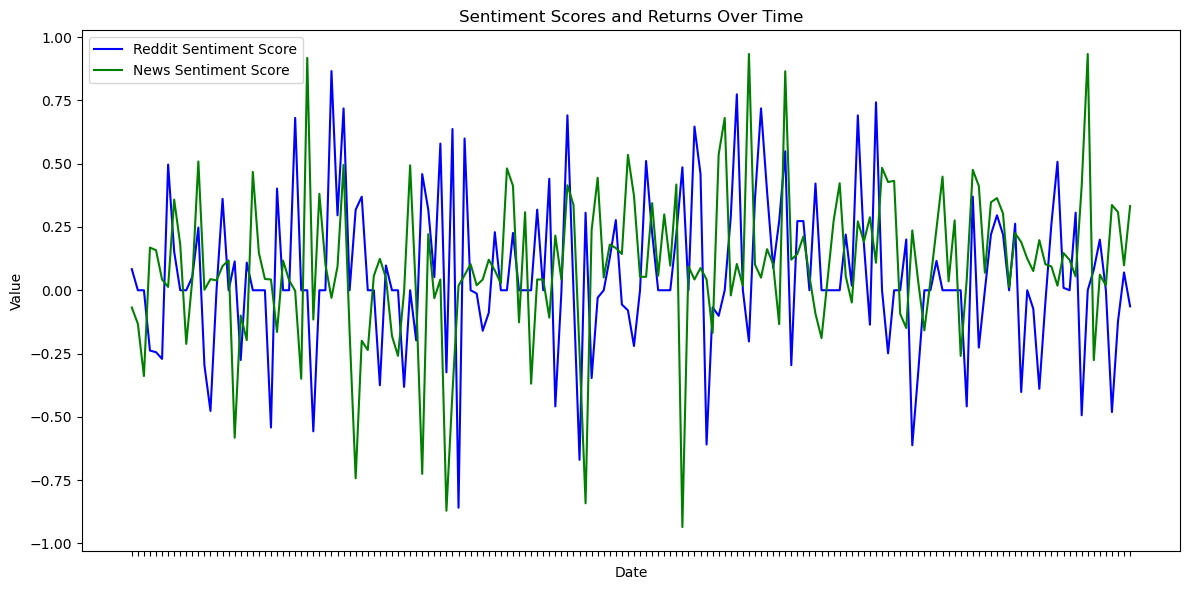

In [58]:

def plot_sentiment_and_prices(df):
    plt.figure(figsize=(12, 6))

    # Plotting the Reddit sentiment scores
    plt.plot(df.index, df['reddit_sentiment'], label='Reddit Sentiment Score', color='blue')
    
    # Plotting the News sentiment scores
    plt.plot(df.index, df['news_sentiment'], label='News Sentiment Score', color='green')
    
    
    # Adding titles and labels
    plt.title('Sentiment Scores and Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.gca().set_xticklabels([]) 
    
    # Adding a legend
    plt.legend()
    
    # Displaying the plot
    plt.tight_layout()
    plt.show()


plot_sentiment_and_prices(apple)
plot_sentiment_and_prices(netflix)


In [59]:
corr = np.corrcoef(apple['reddit_sentiment'].values,apple['news_sentiment'].values)[0,1]
print('{:.2%}'.format(corr))

11.72%


In [60]:
corr = np.corrcoef(netflix['reddit_sentiment'].values,netflix['news_sentiment'].values)[0,1]
print('{:.2%}'.format(corr))

-7.13%


## ADD TECHNICAL FEATURES

In [61]:
apple_df = apple.copy()
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,5].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,5].rolling(window=20).mean() #Close Column
    return data

In [62]:
tech_apple_df = get_tech_ind(apple_df)
apple_dataset = tech_apple_df.iloc[20:,:].reset_index(drop=True)
apple_dataset.head()

,reddit_sentiment,news_sentiment,open,high,low,close,volume,return,MA7,MA20
0,0.085820,0.026701,175.070007,176.130005,173.740005,175.839996,46311900.0,0.007737,176.588573,185.531501
1,0.802000,0.107610,177.059998,177.679993,176.250000,177.229996,42084200.0,0.007905,176.482858,184.796001
2,-0.032075,0.053650,178.520004,181.550003,178.330002,181.119995,52722800.0,0.021949,176.958572,184.214500
3,-0.259267,-0.261746,180.669998,181.100006,176.009995,176.380005,54945800.0,-0.026171,176.518572,183.352501
4,-0.057600,-0.152210,177.380005,179.149994,175.820007,178.610001,51449600.0,0.012643,176.810000,182.558001


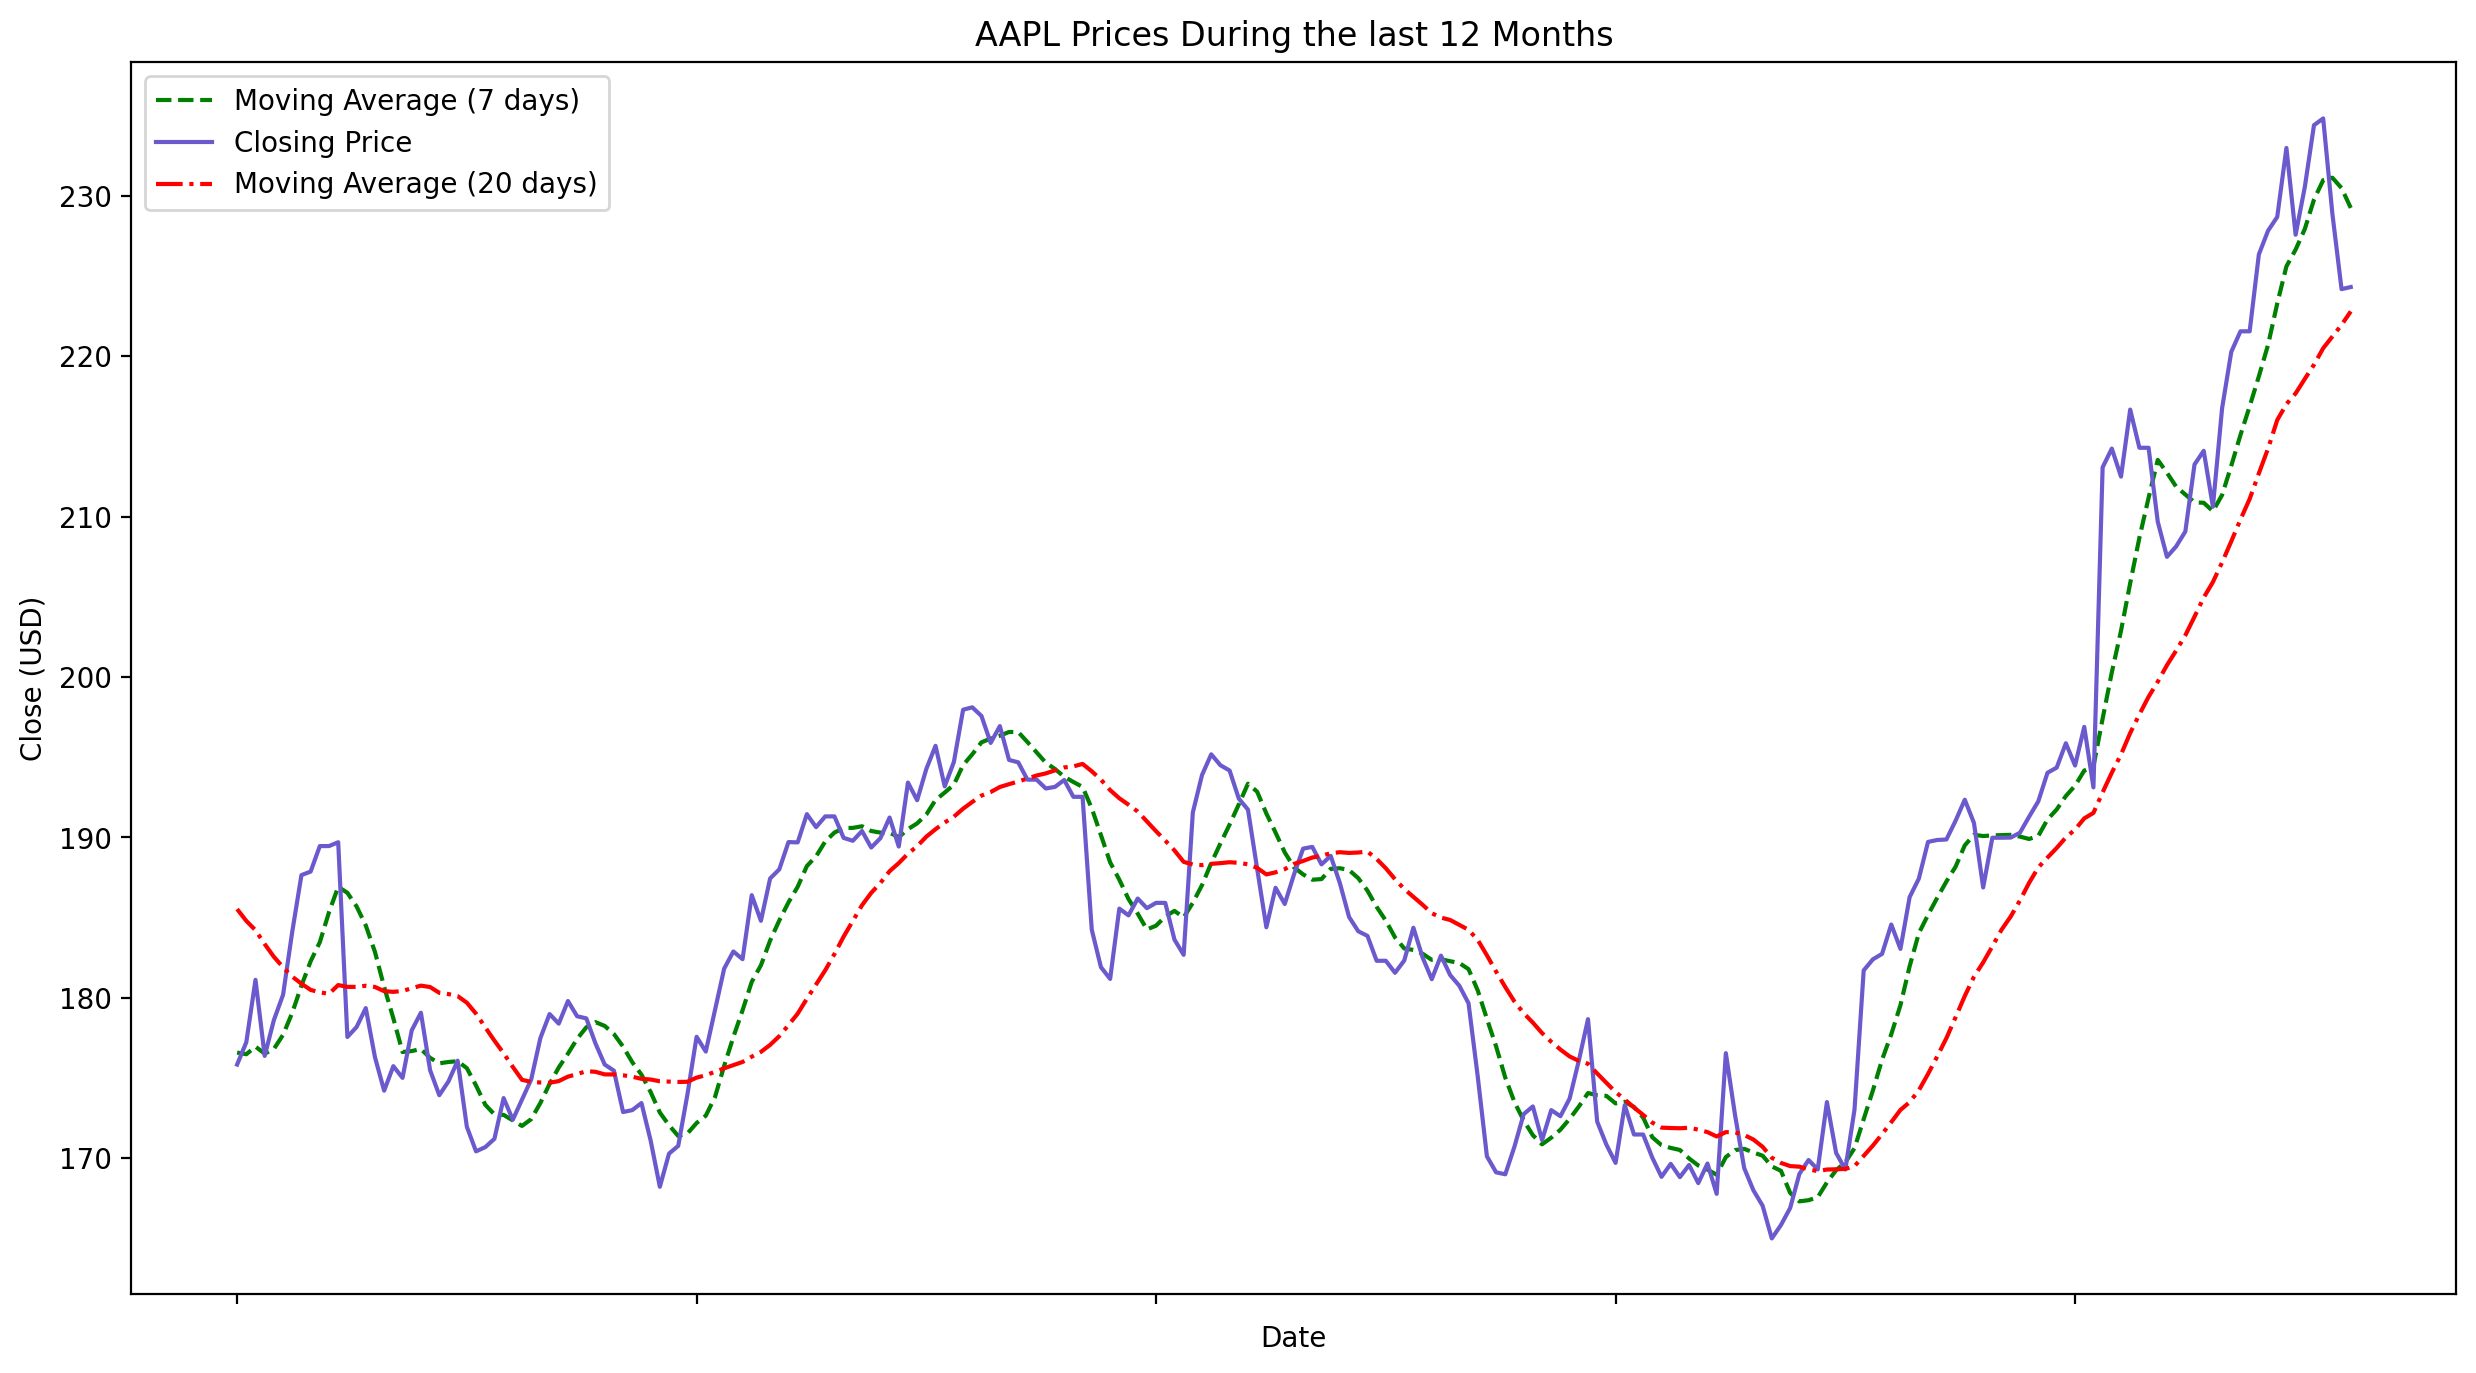

In [63]:
from matplotlib.dates import DateFormatter
def tech_ind(dataset, ticker):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset.index, dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset.index, dataset['close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset.index, dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.set_xticklabels([])
    plt.title(f'{ticker} Prices During the last 12 Months')
    plt.ylabel('Close (USD)')
    plt.xlabel("Date")
    plt.legend()

    plt.show()
    
tech_ind(apple_dataset, "AAPL")



## CORRELATION ANALYSIS

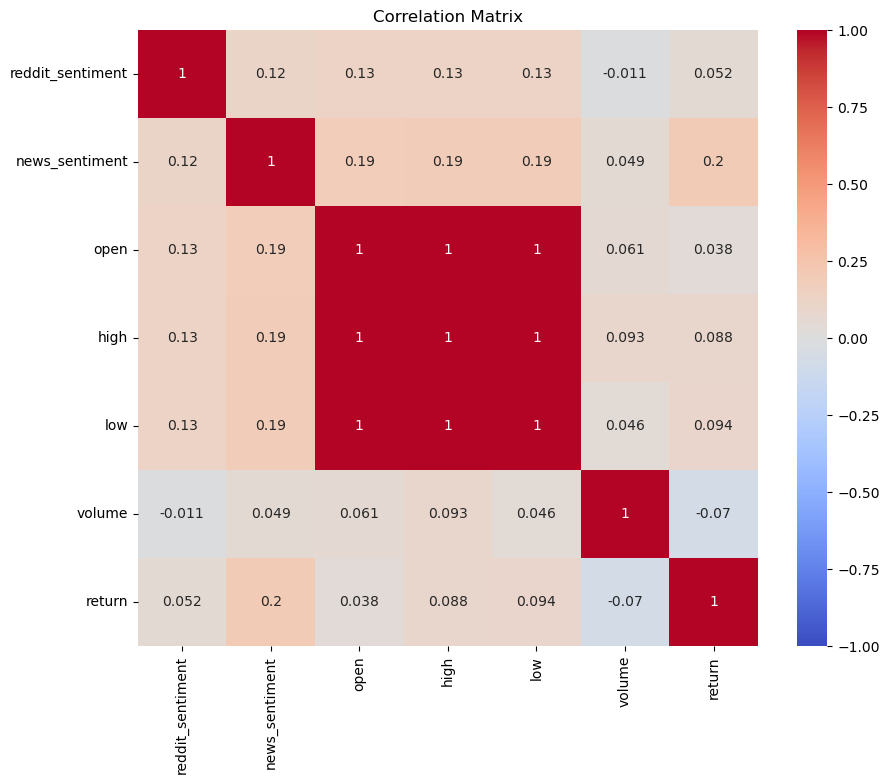

            Feature           VIF
0  reddit_sentiment      1.177662
1    news_sentiment      1.195967
2              open  60729.755112
3              high  39679.772414
4               low  50102.446949
5            volume     11.053416
6            return      2.198927


In [64]:
df1 = apple.copy()

# Drop 'close' column
df1.drop(['close'], axis=1, inplace=True)

# Calculate correlation matrix
corr_matrix = df1.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Calculate VIF
X = df1  # Exclude the target variable
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


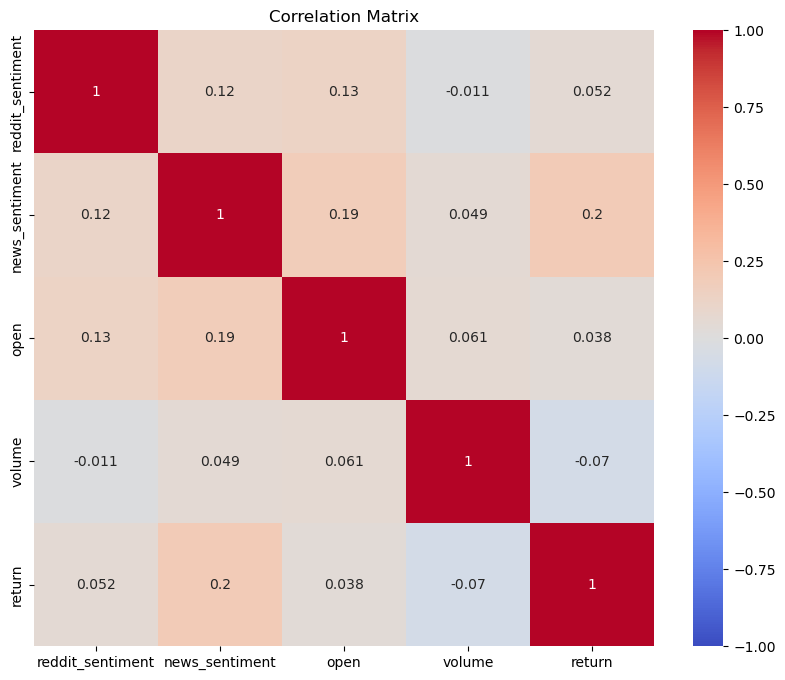

In [65]:
df2 = df1.copy()

# Drop 'high' and 'low' columns
df2.drop(['high', 'low'], axis=1, inplace=True)

# Calculate correlation matrix
corr_matrix = df2.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [66]:
df2

,reddit_sentiment,news_sentiment,open,volume,return
date,,,,,
2023-07-20,0.011200,-0.150490,195.089996,59581200.0,-0.006162
2023-07-21,0.285760,-0.174370,194.100006,71917800.0,-0.006162
2023-07-24,0.427750,-0.093626,193.410004,45377800.0,0.004220
2023-07-25,0.072240,0.294939,193.330002,37283200.0,0.004514
2023-07-26,0.275667,0.186163,193.669998,47471900.0,0.004545
...,...,...,...,...,...
2024-07-15,-0.001917,0.030441,236.479996,62631300.0,0.016743
2024-07-16,0.003371,0.133982,235.000000,43234300.0,0.001792
2024-07-17,-0.094990,0.032509,229.449997,57345900.0,-0.025296


## EXAMINE AUTOCORRELATION 

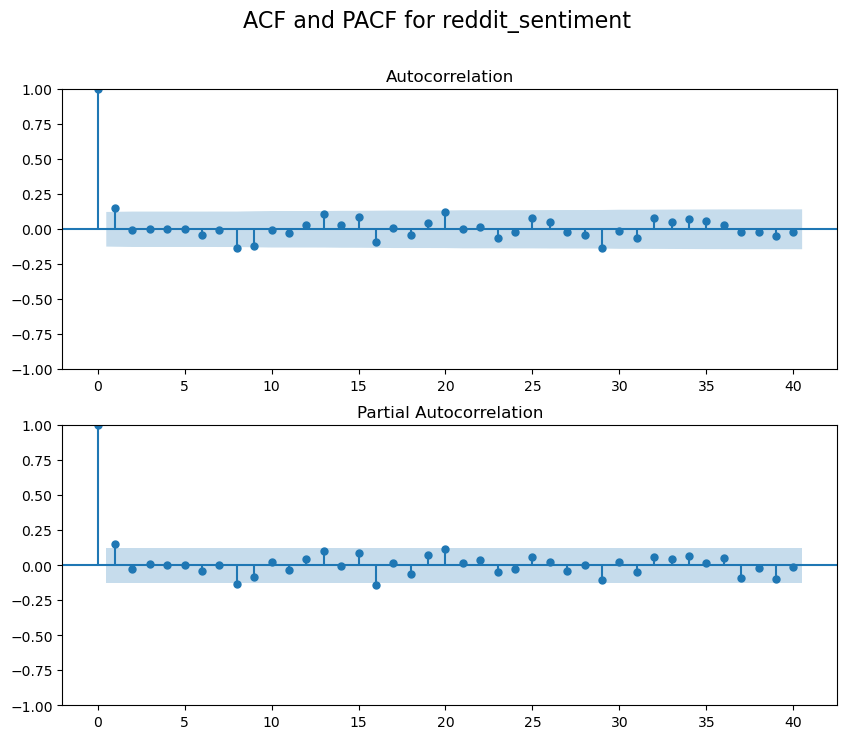

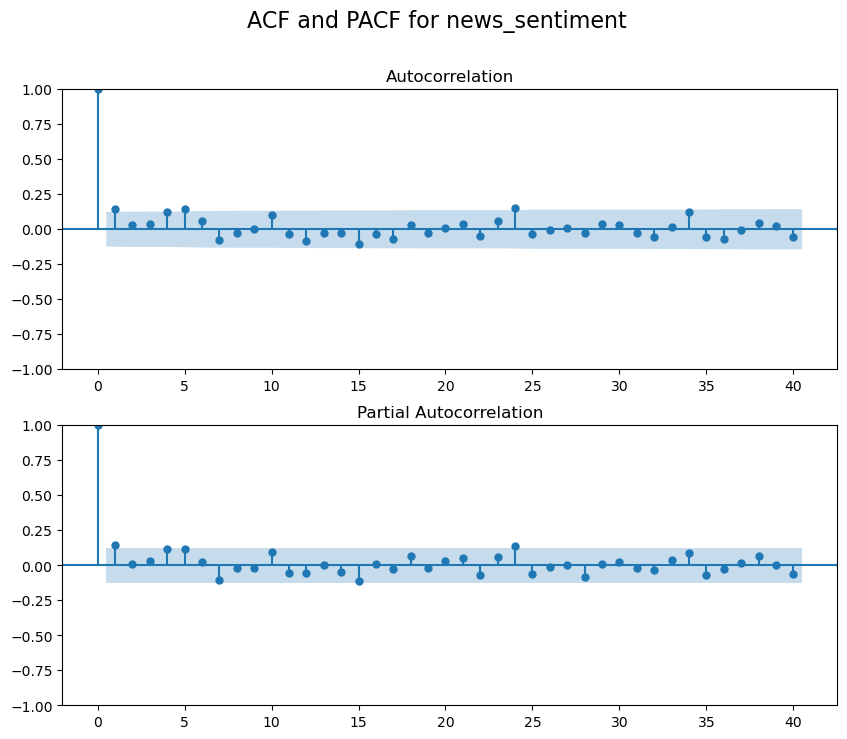

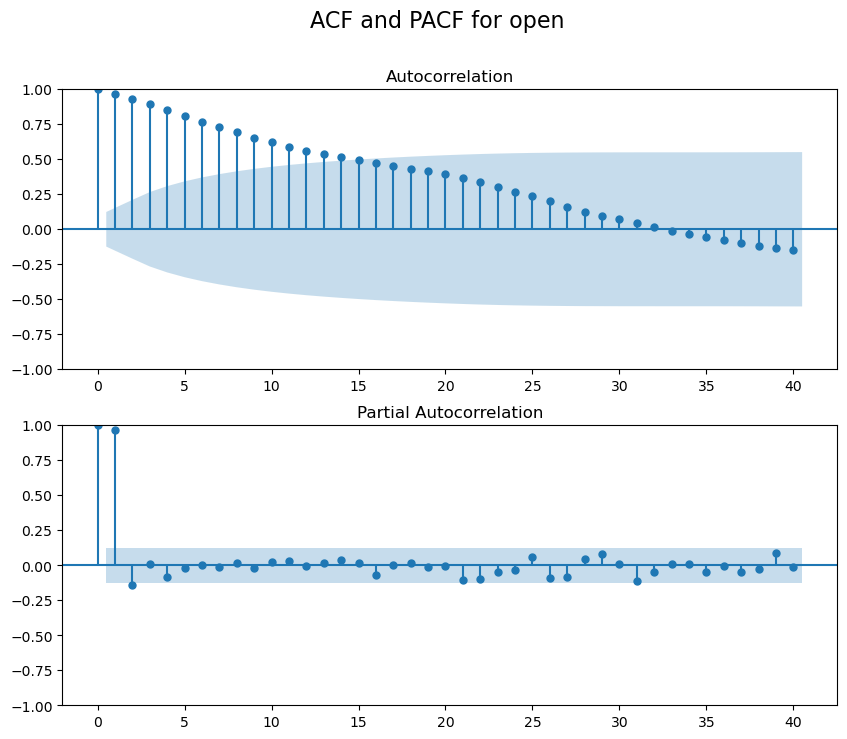

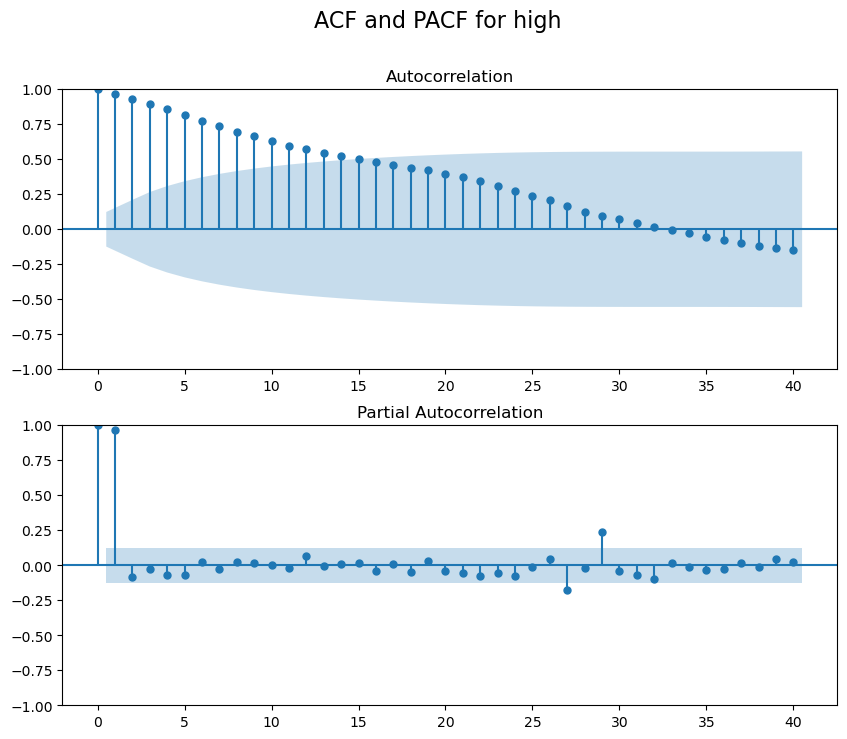

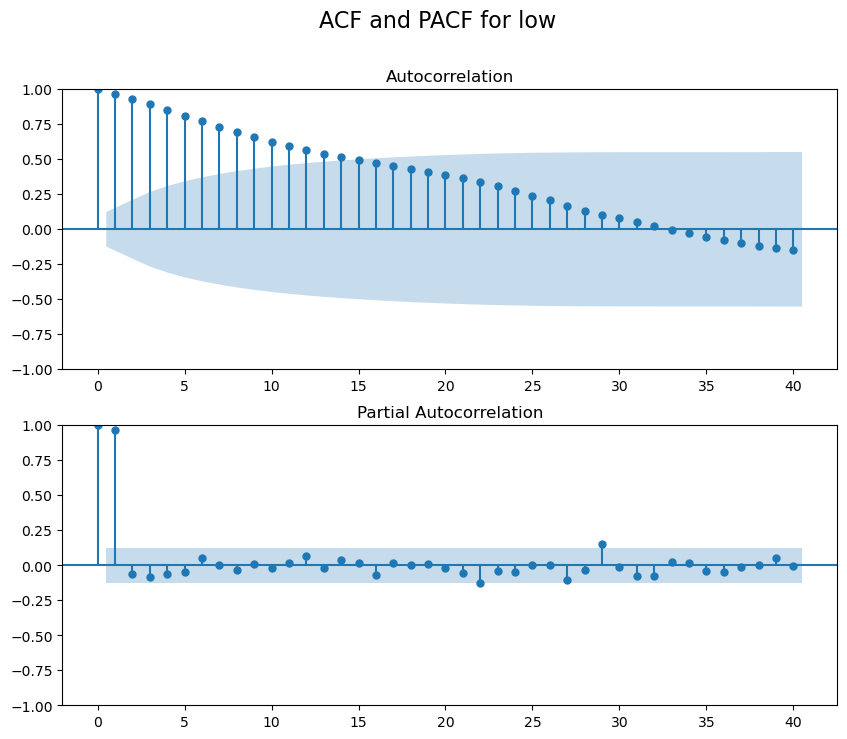

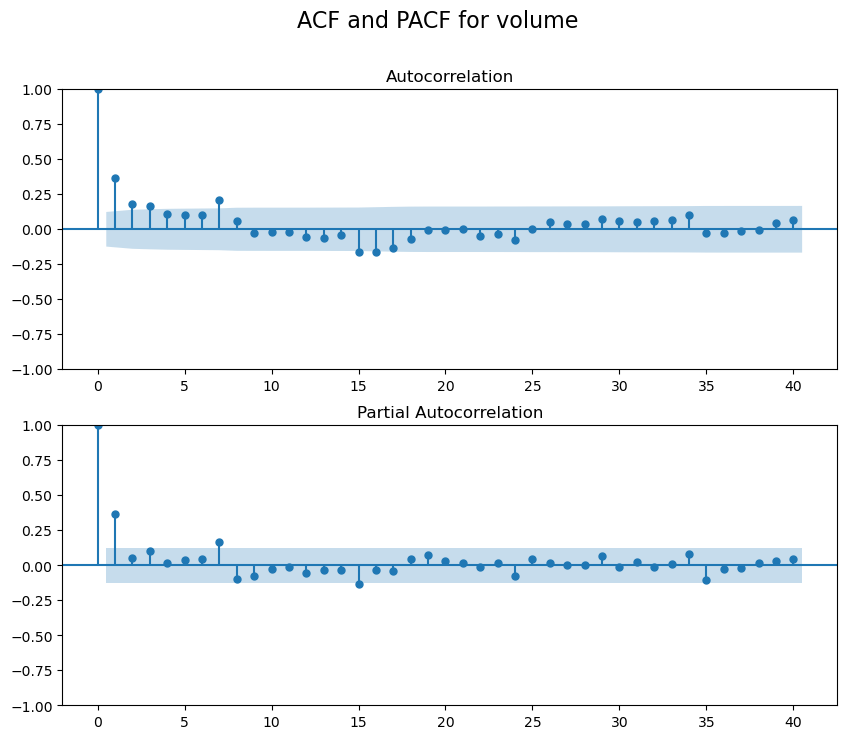

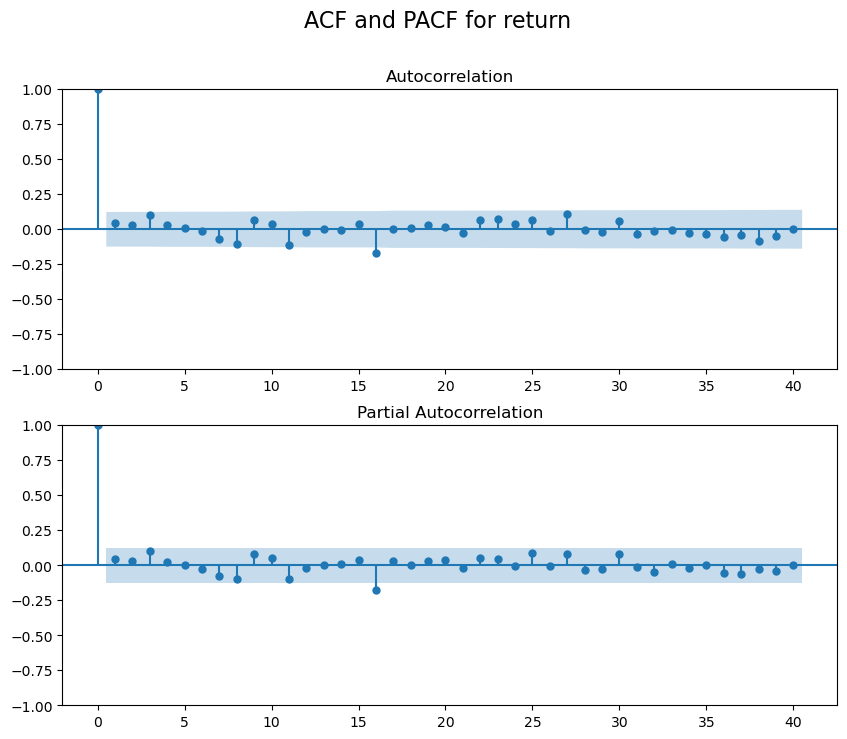

In [67]:
# Define a function to plot ACF and PACF
def plot_acf_pacf(series, lags=40, title=''):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    sm.graphics.tsa.plot_acf(series, lags=lags, ax=ax[0])
    sm.graphics.tsa.plot_pacf(series, lags=lags, ax=ax[1])
    plt.suptitle(f'ACF and PACF for {title}', fontsize=16)
    plt.show()

# Plot ACF and PACF for each feature
for column in df1.columns:
    plot_acf_pacf(df1[column], title=column)


## CHECK STATIONARY

In [68]:
# Define a function to perform ADF test
def adf_test(series, title=''):
    result = adfuller(series, autolag='AIC')
    print(f'Augmented Dickey-Fuller Test: {title}')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())  # To display in tabular format
    if result[1] <= 0.05:
        print("Reject the null hypothesis => Time series is stationary")
    else:
        print("Fail to reject the null hypothesis => Time series is non-stationary")
    print()

# Perform ADF test on each feature
for column in df1.columns:
    adf_test(df1[column], title=column)


Augmented Dickey-Fuller Test: reddit_sentiment
ADF Test Statistic            -1.352239e+01
p-value                        2.719121e-25
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
Reject the null hypothesis => Time series is stationary

Augmented Dickey-Fuller Test: news_sentiment
ADF Test Statistic            -1.361688e+01
p-value                        1.827927e-25
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
Reject the null hypothesis => Time series is stationary

Augmented Dickey-Fuller Test: open
ADF Test Statistic              -0.381647
p-value                          0.913118
#Lags Used                       0.000000
Number of Observa

In [69]:
# Apply differencing
df_diff = df1.diff().dropna()

# Perform ADF test again on differenced data
for column in df_diff.columns:
    adf_test(df_diff[column], title=f'{column} Differenced')


Augmented Dickey-Fuller Test: reddit_sentiment Differenced
ADF Test Statistic            -8.316750e+00
p-value                        3.663311e-13
#Lags Used                     1.300000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
Reject the null hypothesis => Time series is stationary

Augmented Dickey-Fuller Test: news_sentiment Differenced
ADF Test Statistic            -8.414921e+00
p-value                        2.056013e-13
#Lags Used                     8.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
Reject the null hypothesis => Time series is stationary

Augmented Dickey-Fuller Test: open Differenced
ADF Test Statistic            -1.392011e+01
p-value                        5.314755e-26
#Lags Used         

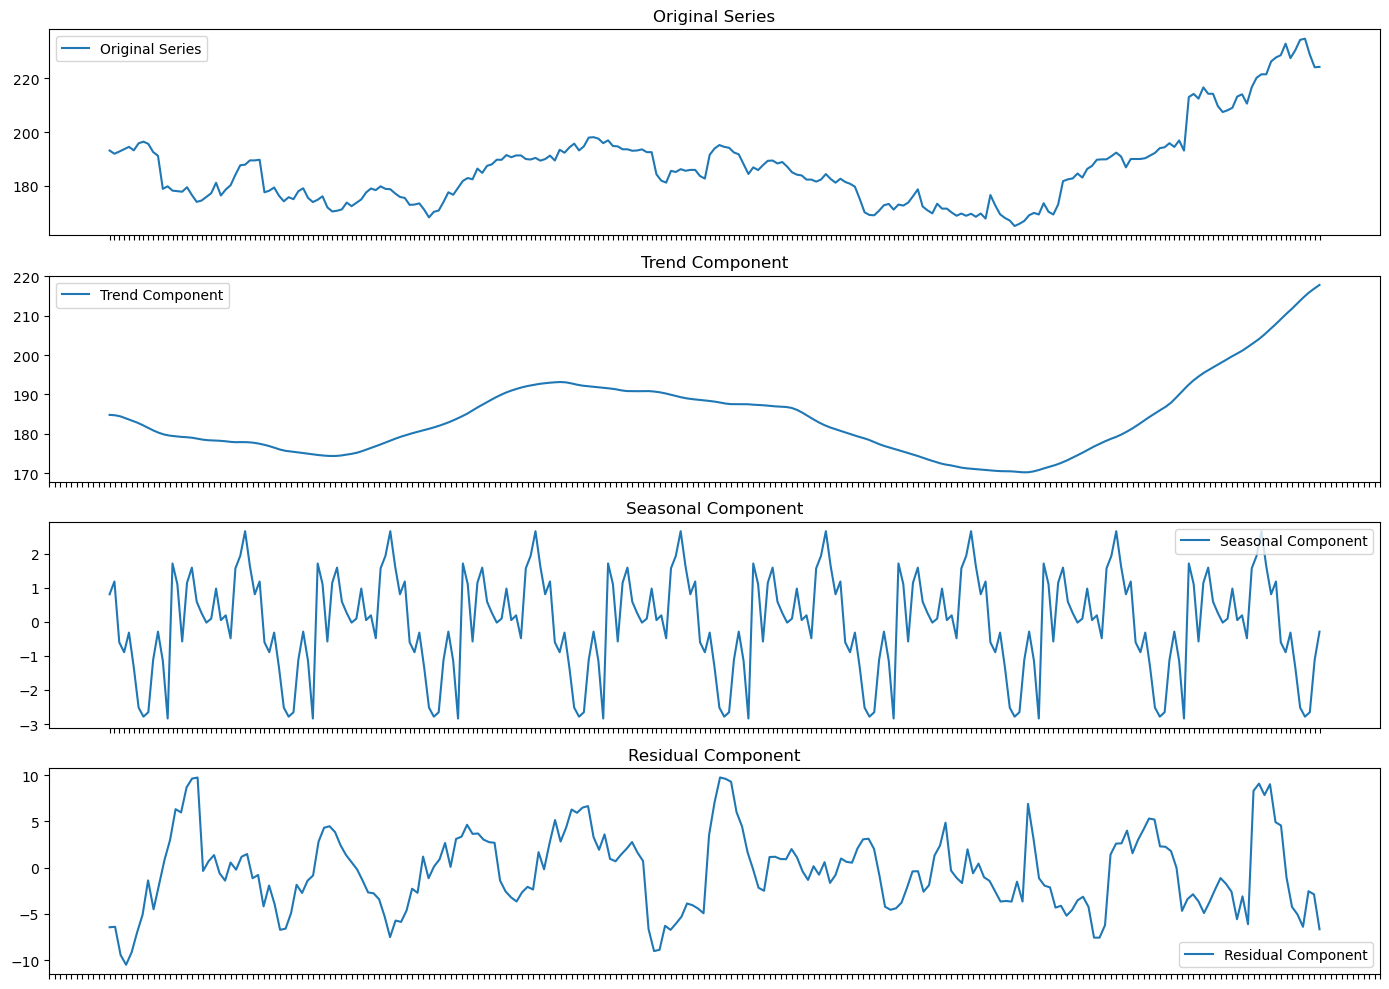

In [70]:

from statsmodels.tsa.seasonal import seasonal_decompose

data = apple_df['close']

# Perform decomposition
decomposition = seasonal_decompose(data, model='additive', period=30)  # Change period as needed

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the components
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(data, label='Original Series')
plt.title('Original Series')
plt.gca().set_xticklabels([]) 
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend Component')
plt.title('Trend Component')
plt.gca().set_xticklabels([]) 
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal Component')
plt.title('Seasonal Component')
plt.gca().set_xticklabels([]) 
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual Component')
plt.title('Residual Component')
plt.gca().set_xticklabels([]) 
plt.legend()

plt.tight_layout()
plt.show()


## MODEL PREP

Normalizes the data using MinMaxScaler from scikit-learn

In [71]:
def normalize_data(df, range, target_column):
    target_df_series = pd.DataFrame(df[target_column])
    feature_df = df.drop(columns=[target_column])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(feature_df)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.transform(feature_df)
    y_scale_dataset = y_scaler.transform(target_df_series)
    
    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return X_scale_dataset, y_scale_dataset


Creates batches for training using sliding windows

In [72]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

Splits the dataset into training and testing sets

In [73]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

Provides the indices of predictions for both training and testing sets

In [74]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [75]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [76]:
dataset = apple.copy()
dataset.drop(['high', 'low'], axis = 1, inplace = True)
dataset 

,reddit_sentiment,news_sentiment,open,close,volume,return
date,,,,,,
2023-07-20,0.011200,-0.150490,195.089996,193.130005,59581200.0,-0.006162
2023-07-21,0.285760,-0.174370,194.100006,191.940002,71917800.0,-0.006162
2023-07-24,0.427750,-0.093626,193.410004,192.750000,45377800.0,0.004220
2023-07-25,0.072240,0.294939,193.330002,193.619995,37283200.0,0.004514
2023-07-26,0.275667,0.186163,193.669998,194.500000,47471900.0,0.004545
...,...,...,...,...,...,...
2024-07-15,-0.001917,0.030441,236.479996,234.399994,62631300.0,0.016743
2024-07-16,0.003371,0.133982,235.000000,234.820007,43234300.0,0.001792
2024-07-17,-0.094990,0.032509,229.449997,228.880005,57345900.0,-0.025296


In [77]:
X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (246, 5, 5)
y shape: (246, 1)
yc shape: (246, 5, 1)


In [78]:
input_dim = X_train.shape[1] 
feature_size = X_train.shape[2] 
output_dim = y_train.shape[1]

## MODEL BUILDING
GAN MODEL

In [79]:
def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([LSTM(units = 1024, return_sequences = True, 
                                    input_shape=(input_dim, feature_size),recurrent_dropout = 0.3),
                               LSTM(units = 512, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 256, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 64, recurrent_dropout = 0.3),
                               Dense(32),
                               Dense(16),
                               Dense(8),
                               Dense(units=output_dim)])
    return model

In [80]:
def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    #cnn_net.add(Flatten())
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [81]:
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

In [82]:
@tf.function

def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

In [83]:
def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint = 50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())

        #Save model every X checkpoints
        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/{stock_name}/generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan/{stock_name}/discriminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())
    
        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)
  
    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    plt.subplot(2,1,1)
    plt.plot(train_info["discriminator_loss"], label='Disc_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(train_info["generator_loss"], label='Gen_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.show()

    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

In [84]:
def plot_results(Real_price, Predicted_price, index_train):
    X_scaler = load(open('/content/X_scaler.pkl', 'rb'))
    y_scaler = load(open('/content/y_scaler.pkl', 'rb'))
    train_predict_index = index_train

    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
  
    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)
  
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)

In [85]:
@tf.function 
def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

In [86]:

def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = index_test

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
  
    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)
  
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)
    
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Price Prediction with GAN for {stock_name}", fontsize=20)
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    plt.show()


In [87]:
import tensorflow as tf
learning_rate = 5e-4
epochs = 500

g_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model(X_train.shape[1])


In [88]:
stock_name = 'AAPL'

 10%|█         | 50/500 [00:21<02:31,  2.96it/s]

epoch 50 discriminator_loss 1.3974531 generator_loss 0.7113423


 20%|██        | 100/500 [00:38<02:23,  2.78it/s]

epoch 100 discriminator_loss 1.3962786 generator_loss 0.684974


 30%|███       | 150/500 [00:54<01:57,  2.99it/s]

epoch 150 discriminator_loss 1.3919027 generator_loss 0.68544775


 40%|████      | 200/500 [01:10<01:39,  3.02it/s]

epoch 200 discriminator_loss 1.3957257 generator_loss 0.7152639


 50%|█████     | 250/500 [01:26<01:27,  2.87it/s]

epoch 250 discriminator_loss 1.37644 generator_loss 0.69938403


 60%|██████    | 300/500 [01:46<01:11,  2.81it/s]

epoch 300 discriminator_loss 1.3916504 generator_loss 0.68555737


 70%|███████   | 350/500 [02:04<00:56,  2.64it/s]

epoch 350 discriminator_loss 1.3833187 generator_loss 0.6989133


 80%|████████  | 400/500 [02:24<00:37,  2.69it/s]

epoch 400 discriminator_loss 1.3833253 generator_loss 0.70243907


 90%|█████████ | 450/500 [02:42<00:17,  2.86it/s]

epoch 450 discriminator_loss 1.3867588 generator_loss 0.69214857


100%|██████████| 500/500 [03:01<00:00,  2.76it/s]


epoch 500 discriminator_loss 1.3870692 generator_loss 0.7059488


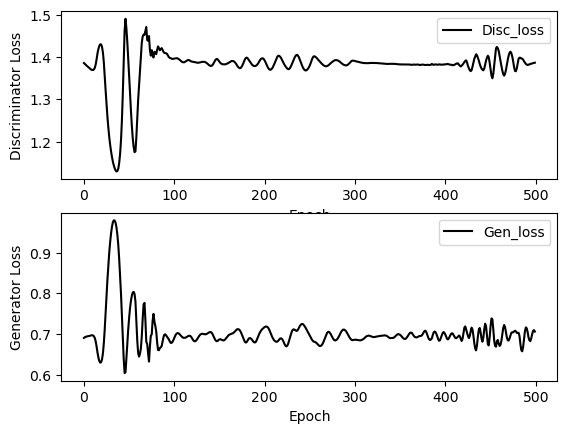

In [89]:
predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)

In [90]:
test_generator = tf.keras.models.load_model(f'./models_gan/{stock_name}/generator_V_{epochs-1}.h5')

Test RMSE:  13.746814817318167


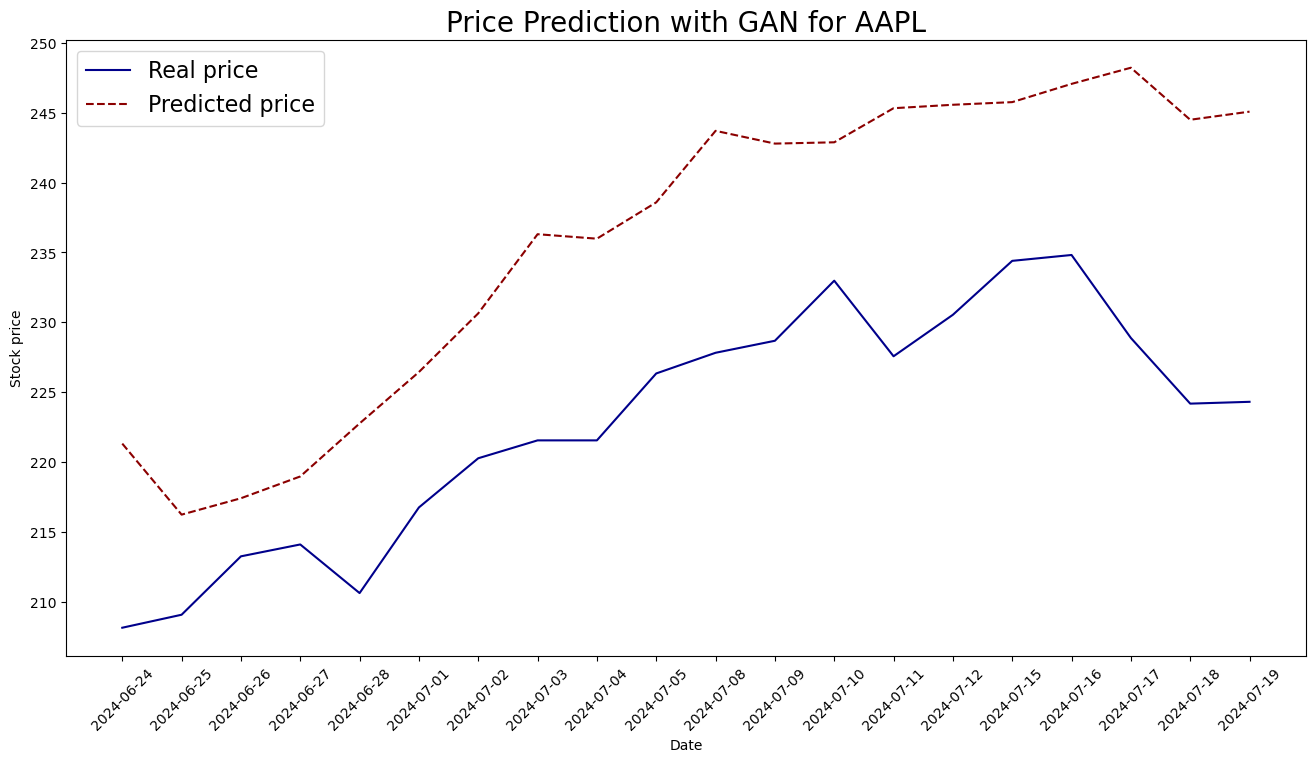

In [91]:
predicted_test_data = eval_op(test_generator, X_test)
plot_test_data(y_test, predicted_test_data,index_test)

## LSTM

In [92]:
from keras.optimizers import Adam

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2596 - val_loss: 0.5769
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0572 - val_loss: 0.6049
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0457 - val_loss: 0.4367
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0315 - val_loss: 0.3001
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0227 - val_loss: 0.2079
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0197 - val_loss: 0.1403
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0209 - val_loss: 0.1095
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0188 - val_loss: 0.1059
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0145 - val_loss: 0.1023
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0133 - val_loss: 0.1149
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0118 - val_loss: 0.1078
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0147 - val_loss: 0.0980
Epoch 13/50


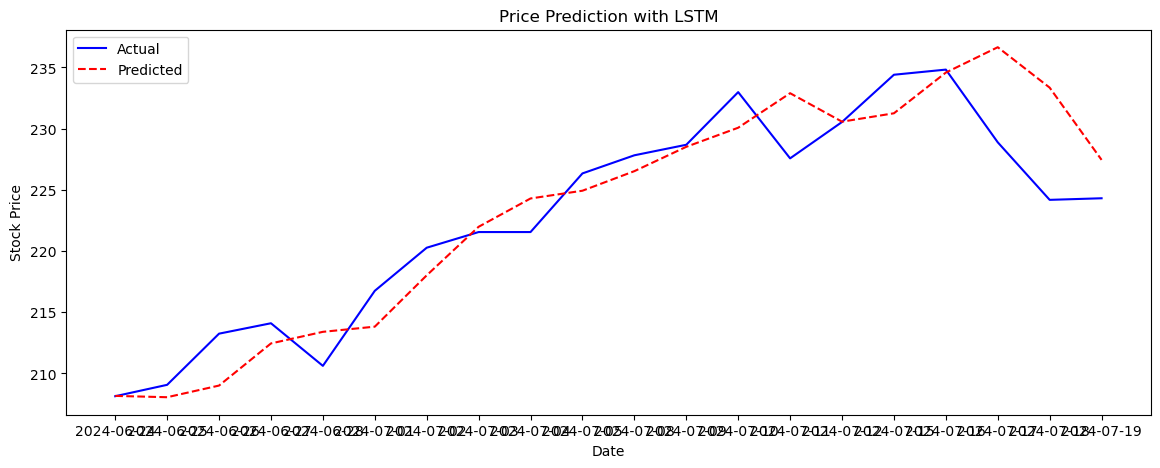

In [93]:
# Calculate input dimensions
input_dim = X_train.shape[1]  # Length of the sequence (batch_size)
feature_size = X_train.shape[2]  # Number of features
output_dim = y_train.shape[1]  # Length of the output sequence (predict_period)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(input_dim, feature_size)))
model.add(LSTM(units=50))
model.add(Dense(units=output_dim))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Rescale predictions back to original scale
y_scaler = load(open('y_scaler.pkl', 'rb'))
y_train_pred_rescaled = y_scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = y_scaler.inverse_transform(y_test_pred)
y_train_rescaled = y_scaler.inverse_transform(y_train)
y_test_rescaled = y_scaler.inverse_transform(y_test)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(dataset.index[-len(y_test_rescaled):], y_test_rescaled[:, -1], color='blue', label='Actual')
plt.plot(dataset.index[-len(y_test_rescaled):], y_test_pred_rescaled[:, -1], color='red', linestyle='dashed', label='Predicted')
plt.title('Price Prediction with LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [94]:
# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_test_pred_rescaled))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 3.2405186157967556
Test RMSE: 3.5740268089689096


## XG Boost

In [95]:
from xgboost import XGBRegressor

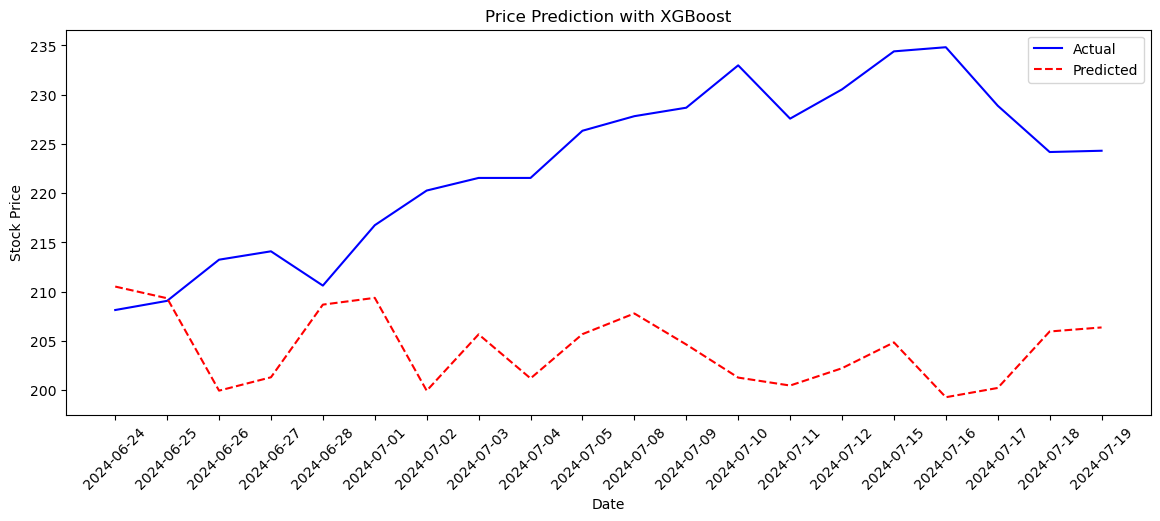

In [96]:
from xgboost import XGBRegressor
from joblib import dump, load
import matplotlib.pyplot as plt

# Flatten the input data for XGBoost
X_train_flat = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test_flat = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))
y_train_flat = y_train.reshape((y_train.shape[0], y_train.shape[1]))
y_test_flat = y_test.reshape((y_test.shape[0], y_test.shape[1]))

# Build the XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8)

# Train the model
model.fit(X_train_flat, y_train_flat)

# Make predictions
y_train_pred = model.predict(X_train_flat)
y_test_pred = model.predict(X_test_flat)

# Reshape predictions for inverse transform
y_train_pred_reshaped = y_train_pred.reshape(-1, 1)
y_test_pred_reshaped = y_test_pred.reshape(-1, 1)
y_train_flat_reshaped = y_train_flat.reshape(-1, 1)
y_test_flat_reshaped = y_test_flat.reshape(-1, 1)

# Rescale predictions back to original scale
y_scaler = load(open('y_scaler.pkl', 'rb'))
y_train_pred_rescaled = y_scaler.inverse_transform(y_train_pred_reshaped)
y_test_pred_rescaled = y_scaler.inverse_transform(y_test_pred_reshaped)
y_train_rescaled = y_scaler.inverse_transform(y_train_flat_reshaped)
y_test_rescaled = y_scaler.inverse_transform(y_test_flat_reshaped)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(dataset.index[-len(y_test_rescaled):], y_test_rescaled[:, -1], color='blue', label='Actual')
plt.plot(dataset.index[-len(y_test_rescaled):], y_test_pred_rescaled[:, -1], color='red', linestyle='dashed', label='Predicted')
plt.title('Price Prediction with XGBoost')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [97]:
# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_test_pred_rescaled))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 0.1495882473393411
Test RMSE: 21.260277052550816


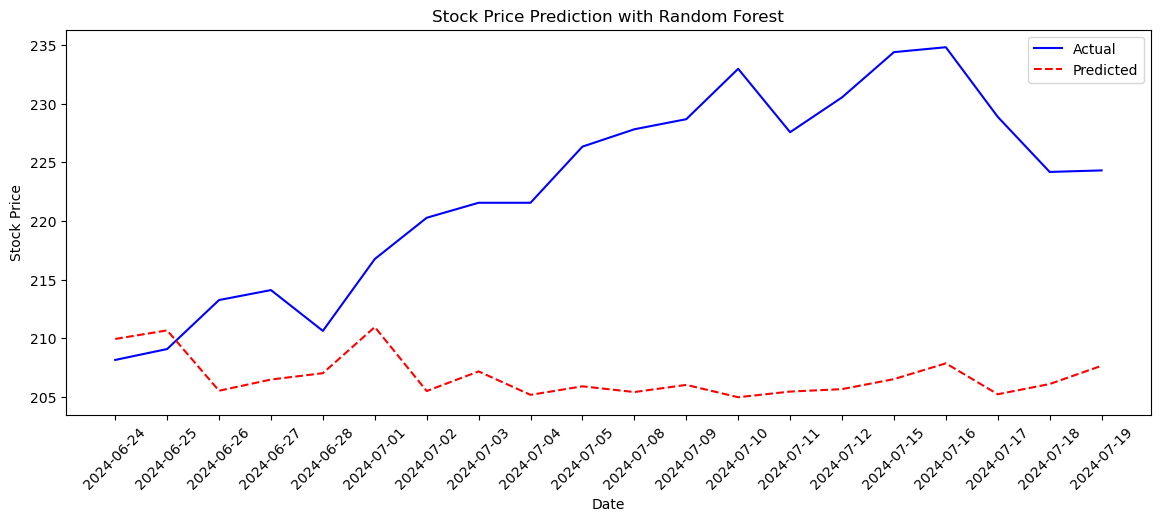

In [98]:
from sklearn.ensemble import RandomForestRegressor
# Build the Random Forest model
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Train the model
model.fit(X_train_flat, y_train_flat.ravel())

# Make predictions
y_train_pred = model.predict(X_train_flat)
y_test_pred = model.predict(X_test_flat)

# Reshape predictions for inverse transform
y_train_pred_reshaped = y_train_pred.reshape(-1, 1)
y_test_pred_reshaped = y_test_pred.reshape(-1, 1)
y_train_flat_reshaped = y_train_flat.reshape(-1, 1)
y_test_flat_reshaped = y_test_flat.reshape(-1, 1)

# Rescale predictions back to original scale
y_scaler = load(open('y_scaler.pkl', 'rb'))
y_train_pred_rescaled = y_scaler.inverse_transform(y_train_pred_reshaped)
y_test_pred_rescaled = y_scaler.inverse_transform(y_test_pred_reshaped)
y_train_rescaled = y_scaler.inverse_transform(y_train_flat_reshaped)
y_test_rescaled = y_scaler.inverse_transform(y_test_flat_reshaped)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(dataset.index[-len(y_test_rescaled):], y_test_rescaled[:, -1], color='blue', label='Actual')
plt.plot(dataset.index[-len(y_test_rescaled):], y_test_pred_rescaled[:, -1], color='red', linestyle='dashed', label='Predicted')
plt.title('Stock Price Prediction with Random Forest')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [99]:
# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_test_pred_rescaled))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 1.292666829527074
Test RMSE: 18.526529896536324


## GRU

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0996 - val_loss: 0.6032
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0458 - val_loss: 0.2071
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0262 - val_loss: 0.0875
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0132 - val_loss: 0.0321
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0116 - val_loss: 0.0186
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0139 - val_loss: 0.0342
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0118 - val_loss: 0.0355
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101 - val_loss: 0.0346
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086 - val_loss: 0.0272
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0088 - val_loss: 0.0205
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087 - val_loss: 0.0181
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0088 - val_loss: 0.0188
Epoch 13/50


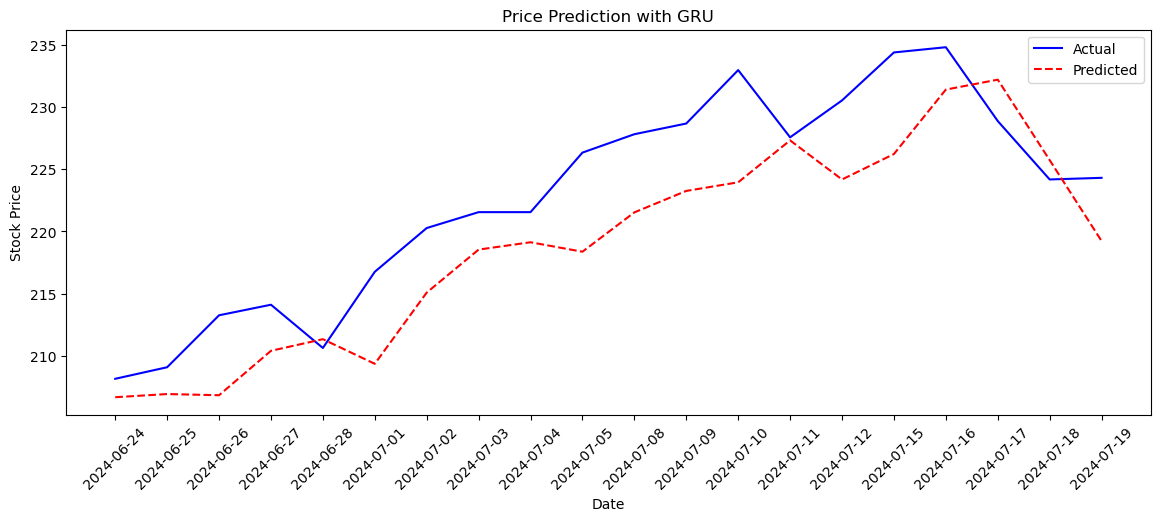

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from joblib import load

# Calculate input dimensions
input_dim = X_train.shape[1]  # Length of the sequence (batch_size)
feature_size = X_train.shape[2]  # Number of features
output_dim = y_train.shape[1]  # Length of the output sequence (predict_period)

# Build the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(input_dim, feature_size)))
model.add(GRU(units=50))
model.add(Dense(units=output_dim))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Rescale predictions back to original scale
y_scaler = load(open('y_scaler.pkl', 'rb'))
y_train_pred_rescaled = y_scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = y_scaler.inverse_transform(y_test_pred)
y_train_rescaled = y_scaler.inverse_transform(y_train)
y_test_rescaled = y_scaler.inverse_transform(y_test)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(dataset.index[-len(y_test_rescaled):], y_test_rescaled[:, -1], color='blue', label='Actual')
plt.plot(dataset.index[-len(y_test_rescaled):], y_test_pred_rescaled[:, -1], color='red', linestyle='dashed', label='Predicted')
plt.title('Price Prediction with GRU')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [101]:
# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_test_pred_rescaled))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 3.38715069073899
Test RMSE: 5.155829518993505
